In [72]:
from asyncio import get_event_loop
from websockets import serve
from matplotlib import pyplot as plt
from matplotlib import patches
from skimage import io, transform
from skimage import color, data, restoration
from collections import Counter
from pylibdmtx.pylibdmtx import decode
from multiprocessing import Pool
from io import BytesIO, StringIO
from json import dumps, loads, load
from uuid import uuid4
from math import cos, sin, pi
import base64
from glob import glob
%matplotlib inline

In [69]:
def decode_thread(pp_more):
    if pp_more['well'].shape[0] > 0 and pp_more['well'].shape[1] > 0:
        # try shrink
        res = decode(pp_more['well'], shrink=2, max_count=1)
        if res and res[0].data.decode().isnumeric():
            return {**pp_more['pp'], 'barcode': res[0].data.decode()}
        # try defaults
        res = decode(pp_more['well'], max_count=1)
        if res and res[0].data.decode().isnumeric():
            return {**pp_more['pp'], 'barcode': res[0].data.decode()}
        # try threshold
        res = decode(pp_more['well'], threshold=100, max_count=1)
        if res and res[0].data.decode().isnumeric():
            return {**pp_more['pp'], 'barcode': res[0].data.decode()}
    return {**pp_more['pp'], 'barcode': "failed"}


def map_wells(col, row, orientation):
    if orientation == 'landscape':  # "normal". A1 is top left
        return f"{['A','B','C','D','E','F','G','H'][row]}{col+1}"
    else:  # rotated 90 degrees right
        return f"{['H','G','F','E','D','C','B','A'][col]}{row+1}"


def analyze_image(image, pps):
    wells = [{'pp':pp, 'well': image[pp['minY']:pp['maxY'], pp['minX']:pp['maxX']]} for pp in pps]
    with Pool(8) as p:
        rar = p.map(decode_thread, wells)
    return rar

In [153]:
print(glob("../*.json"))
files = glob("../*.json")

['../b57d2866-f9a6-4375-88bc-af92b4d5bde6.json', '../0f37293e-dd4b-4691-bbce-5778e997c0e7.json', '../4aec193a-5f8a-4d63-a8a4-e98607b1828d.json', '../3ae3eb41-412e-4816-b294-2b04ac18456b.json', '../c234cddc-b9e9-4d36-91e8-211d84b5b13e.json']


In [170]:
print(image_zero.shape)
print(len(images))
#(1440, 1920,
# ./4aec193a-5f8a-4d63-a8a4-e9
# 3ae3eb41-412

(2160, 3840, 4)
5


In [ ]:
all_data = load(open(files[0], 'r'))

In [ ]:
grid = all_data['grid']
iscale = all_data['scale']
images = all_data['images']
image_zero = io.imread(BytesIO(base64.decodebytes(images[0]['src'].split(',')[1].encode())))

scale = image_zero.shape[1] / iscale
if grid['width'] > grid['height']:
    grid_size = (grid['width'] / 12) * scale
    orientation = "landscape"
    no_rows = 8
    no_cols = 12
else:
    grid_size = (grid['height'] / 12) * scale
    orientation = "portrait"
    no_rows = 12
    no_cols = 8
width = grid_size * grid['scaleX']
height = grid_size * grid['scaleY']
ori_x = grid['left'] * scale
ori_y = grid['top'] * scale
angle = (grid['angle'] / 360) * 2 * pi
pps = []
for row in range(no_rows):
    for col in range(no_cols):
        dx1 = ori_x + width * col * cos(angle) - height * row * sin(angle)
        dx2 = ori_x + width * col * cos(angle) - height * (row + 1) * sin(angle)
        dx3 = ori_x + width * (col + 1) * cos(angle) - height * (row + 1) * sin(angle)
        dx4 = ori_x + width * (col + 1) * cos(angle) - height * row * sin(angle)
        dxs = [dx1, dx2, dx3, dx4]
        dy1 = ori_y + width * col * sin(angle) + height * row * cos(angle)
        dy2 = ori_y + width * col * sin(angle) + height * (row + 1) * cos(angle)
        dy3 = ori_y + width * (col + 1) * sin(angle) + height * (row + 1) * cos(angle)
        dy4 = ori_y + width * (col + 1) * sin(angle) + height * row * cos(angle)
        dys = [dy1, dy2, dy3, dy4]

        pps.append({'col':col, 'row': row, 'minY': int(min(dys)), 'maxY': int(max(dys)), 'minX': int(min(dxs)), 'maxX': int(max(dxs)), 'x0': dx1, 'y0':dy1})


results = [analyze_image(io.imread(BytesIO(base64.decodebytes(image['src'].split(',')[1].encode()))), pps) for image in images]

# analyze results
rar = [] #list of well objects with {'row', 'col', 'barcode', 'x0', 'y0'}
for well_no in range(no_rows*no_cols):
    #check that its the same well
    if len(set([results[i][well_no]['col'] for i in range(len(results))]))==1 and len(set([results[i][well_no]['row'] for i in range(len(results))]))==1:
        barcodes = [results[i][well_no]['barcode'] for i in range(len(results)) if results[i][well_no]['barcode'] != 'failed']
        barcodes_set = set(barcodes)
        if len(barcodes_set) == 1:
            rar.append({**results[0][well_no], 'barcode':barcodes_set.pop()})
        elif len(barcodes_set) == 0:
            rar.append({**results[0][well_no], 'barcode':'failed'})
        else:
            #lets see if theres a concensus
            barcodes_counter = Counter(barcodes)
            two_most_common = barcodes_counter.most_common(2)
            if two_most_common[0][1] == two_most_common[1][1]: # cant decide
                rar.append({**results[0][well_no], 'barcode': f"uncertain: {barcodes}"})
            else:
                rar.append({**results[0][well_no], 'barcode': two_most_common[0][0]})
    else:
        print("error...not same well?")

# draw result consensus
fig, ax = plt.subplots(1, figsize=(10, 20))
ax.imshow(image_zero)
rect = patches.Rectangle((grid['left'] * scale, grid['top'] * scale), width=grid['width'] * grid['scaleX'] * scale,
                                                 height=grid['height'] * grid['scaleY'] * scale, angle=grid['angle'], linewidth=1,
                                                 edgecolor='r', facecolor='none')
ar_pa = patches.Arrow(grid['left'] * scale, grid['top'] * scale, cos(((grid['angle'] - 90) / 360) * (2 * pi)) * 50,
                                            sin(((grid['angle'] - 90) / 360) * (2 * pi)) * 50, color='green', width=10)
ax.add_patch(rect)
ax.add_patch(ar_pa)

for irar in rar:
    if irar['barcode'] == 'failed':
        color = 'red'
        lw = 3
    elif 'uncertain' in irar['barcode']:
        color = 'blue'
        lw = 3
    else:
        color = 'green'
        lw = 1
    mrect = patches.Rectangle((irar['x0'], irar['y0']), width=width, height=height, angle=grid['angle'], linewidth=lw, edgecolor=color,facecolor='none')
    ax.add_patch(mrect)


plt.show()
#return
rrar = [{'loc': map_wells(entry['col'], entry['row'], orientation), 'barcode': entry['barcode']} for entry in rar]


In [113]:
import pandas as pd
from scipy.signal import convolve2d as conv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float, color
from skimage.util import random_noise


import numpy as np

[]
[]
[]
[]
[]


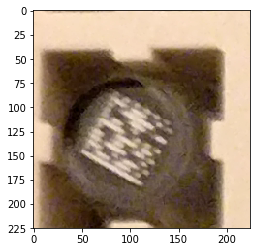

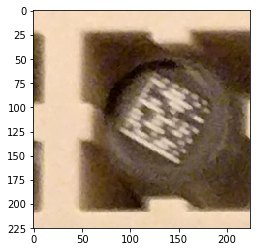

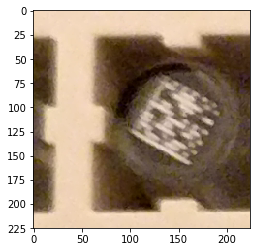

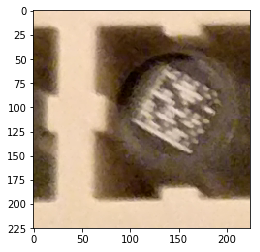

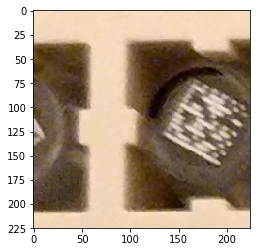

In [167]:
wells = []
for i in range(len(results)):
    f, ax = plt.subplots()
    pp = results[i][13]
    image = io.imread(BytesIO(base64.decodebytes(images[i]['src'].split(',')[1].encode())))
    well = image[pp['minY']:pp['maxY'], pp['minX']:pp['maxX']]
    
    #well2 = denoise_tv_chambolle(well, weight=0.2, multichannel=True)
    print(decode(well, shrink=2, max_count=1))
    ax.imshow(well)
    wells.append(well)

In [59]:
image, timeout=None, gap_size=None, shrink=1, shape=None,
           deviation=None, threshold=None, min_edge=None, max_edge=None,
           corrections=None, max_count=None):

dict

In [136]:
from skimage.util import img_as_ubyte
from skimage.feature import canny
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
ski_image = wells[0]

In [145]:
grey_image = color.rgb2grey(ski_image)
rescaled = transform.rescale(grey_image, 1/scale, multichannel=False)
#edges = filters.sobel(rescaled)
edges2 = canny(rescaled)
#edges3 = feature.canny(rescaled, sigma=4)
thresh = threshold_otsu(edges2)
bw = closing(edges2 > thresh, square(3))
cleared = clear_border(bw)

/home/laeb/.pyenv/versions/3.7.2/envs/scipy/lib/python3.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


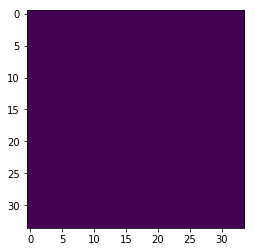

In [149]:
plt.imshow(cleared)

In [129]:
transform.hough_circle_peaks(hough_res, 100)

TypeError: zip argument #1 must support iteration